In [1]:
from new_thesis_library import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_rows = 999
pd.options.display.max_columns = 100

%matplotlib inline

# Moex thetas

In [2]:
moex_thetas = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/Comparing-numerical-methods-for-term-structure-fitting/Data/New_data/moex_dynamic.csv',
                          sep = ';')

moex_thetas['tradedate'] = pd.to_datetime(moex_thetas['tradedate'], format='%d.%m.%Y')
moex_thetas[['B1', 'B2', 'B3', 'T1']] = moex_thetas[['B1', 'B2', 'B3', 'T1']].apply(lambda x: x.str.replace(',','.'))
moex_thetas[['B1', 'B2', 'B3', 'T1']] = moex_thetas[['B1', 'B2', 'B3', 'T1']].astype('float64')
moex_thetas[['B1', 'B2', 'B3']] = moex_thetas[['B1', 'B2', 'B3']]/10000
moex_thetas = moex_thetas[['tradedate', 'T1', 'B1', 'B2', 'B3']]
moex_thetas.set_index('tradedate', inplace = True)

/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/Comparing-numerical-methods-for-term-structure-fitting/new_thesis_library.py:41: RuntimeWarning: invalid value encountered in true_divide
  return beta0 + beta1 * (1 - np.exp(- m / tau)) / (m / tau) + beta2 * ((1 - np.exp(- m / tau)) / (m / tau) - np.exp(- m / tau))


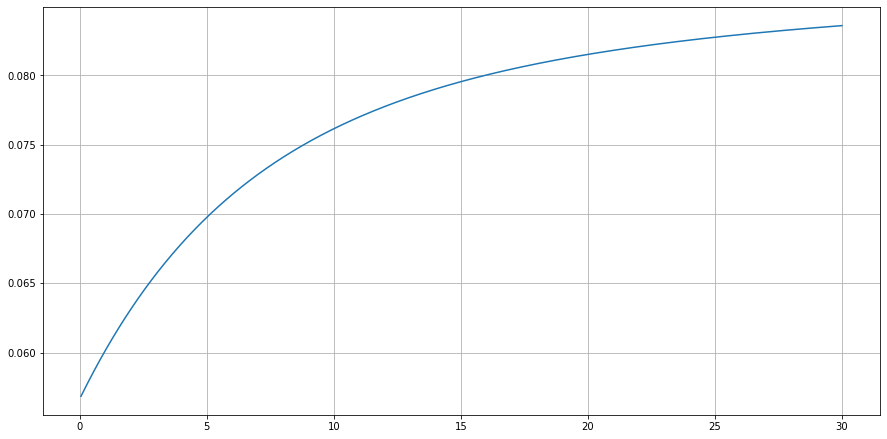

In [3]:
m = np.linspace(0, 30, 600)
plt.figure(figsize = (15,7.5))
plt.grid()
plt.plot(m, ns(m, moex_thetas[0:1].values[0]), label = 'NS curve');

In [9]:
moex_thetas_stats = moex_thetas.describe()
moex_thetas_stats

,T1,B1,B2,B3
count,1643.000000,1643.000000,1643.000000,1643.000000
mean,4.871800,0.087704,-0.011902,0.003621
std,4.515339,0.015014,0.023744,0.038101
min,0.300073,0.055520,-0.063911,-0.073377
25%,1.538723,0.079948,-0.025936,-0.020286
50%,3.381781,0.085636,-0.014949,0.001554
75%,6.234200,0.092933,0.000730,0.022876
max,17.525151,0.130801,0.056864,0.119194


In [15]:
moex_thetas_stats['B1']['min']

0.055519527000000006

# Generating random values

We will be generating random values in the borders of max/min +- 3 std for betas, [0, 30] for tau.

In [25]:
np.random.seed(1)

for i in range(16):
    random_thetas = np.zeros([len(dates), 5])
    for j in range(len(dates)):
        random_thetas[j] = np.array([int(i + 1), 
                                     np.random.uniform(0, 30), 
                                     np.random.uniform(moex_thetas_stats['B1']['min'] - 3 * moex_thetas_stats['B1']['std'], moex_thetas_stats['B1']['max'] + 3 * moex_thetas_stats['B1']['std']), 
                                     np.random.uniform(moex_thetas_stats['B2']['min'] - 3 * moex_thetas_stats['B2']['std'], moex_thetas_stats['B2']['max'] + 3 * moex_thetas_stats['B2']['std']), 
                                     np.random.uniform(moex_thetas_stats['B3']['min'] - 3 * moex_thetas_stats['B3']['std'], moex_thetas_stats['B3']['max'] + 3 * moex_thetas_stats['B3']['std'])])
    random_thetas = pd.DataFrame(random_thetas, columns = ['Value', 'tau', 'beta0', 'beta1', 'beta2'], index = dates)
    random_thetas.to_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/Comparing-numerical-methods-for-term-structure-fitting/Data/New_data/Random_thetas/rand_' + str(i + 1) + '.csv')

# Diebold, Li starting values

### IRR calculation

In [2]:
def npv(irr, cfs, yrs):  
    return np.sum(cfs / (1. + irr) ** yrs)

In [3]:
from scipy.optimize import fsolve

def irr(cfs, yrs, x0):
    return np.asscalar(fsolve(npv, x0=x0, args=(cfs, yrs)))

In [21]:
def maturities_irrs(date_number):
    irrs = []
    maturities = []
    payments_on_date = bonds_payments[bonds_payments['Дата фактической выплаты'] >= dates[date_number]]
    
    for ticker in bond_isins:
    
        payments = payments_on_date[payments_on_date['ISIN'] == ticker]['Сумма купона, RUB'] + payments_on_date[payments_on_date['ISIN'] == ticker]['Погашение номинала, RUB'].values
        payments_dates = (payments_on_date[payments_on_date['ISIN'] == ticker]['Дата фактической выплаты'] - dates[date_number]).apply(lambda x: x.days)/365
        
        investment = bonds_prices.iloc[date_number][ticker]
        payments = np.insert(np.array(payments), 0, -investment)
        payments_dates = np.insert(np.array(payments_dates), 0, 0)
        
        if np.isnan(payments[0]) == True:
            irrs.append(np.nan)
            maturities.append(np.nan)
        else:
            bond_irr = irr(cfs=payments, yrs=payments_dates, x0=0.10)
            irrs.append(bond_irr)
            maturities.append(payments_dates[-1])
            
        
    return (np.array([maturities]), np.array([irrs]))   

In [9]:
irr_matrix = pd.DataFrame(np.zeros(bonds_prices.shape), index = dates, columns = bond_isins)
maturity_matrix = pd.DataFrame(np.zeros(bonds_prices.shape), index = dates, columns = bond_isins)

In [10]:
%%time

for i in range(len(dates)):
    maturity_matrix[dates[i]:dates[i]], irr_matrix[dates[i]:dates[i]] = maturities_irrs(i)    

/Users/andrey_lukyanov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  after removing the cwd from sys.path.


CPU times: user 3min 40s, sys: 559 ms, total: 3min 41s
Wall time: 3min 41s


In [70]:
maturity_matrix.to_csv(path + 'Data/New_data/bonds_maturities.csv')
irr_matrix.to_csv(path + 'Data/New_data/bonds_irrs.csv')

In [7]:
maturity_matrix = pd.read_csv(path + 'Data/New_data/bonds_maturities.csv', index_col='TRADEDATE', parse_dates=True)
irr_matrix = pd.read_csv(path + 'Data/New_data/bonds_irrs.csv', index_col='TRADEDATE', parse_dates=True)

## BOOTSRAP

1. Сортируем бонды по их длине
2. Первую ставку взять из IRR наиболее короткого бонда
3. Далее решать каждый бонд при условии более коротких ставок.

In [3]:
from scipy.optimize import fsolve

In [4]:
def discount_by_rates(df, rates):
    df['Discounted'] = (df['Сумма купона, RUB'] + df['Погашение номинала, RUB']) * np.exp(-rates * df['Дата фактической выплаты'])

In [5]:
def generate_solve_for_rate(unknown, known, price):
    def solve_for_rate(rate):
        nonlocal unknown, known, price
        unknown['rates'] = np.ones(unknown.shape[0]) * rate
        discount_by_rates(unknown, unknown['rates'])
        return known + unknown.Discounted.sum() - price    
    
    return solve_for_rate

In [6]:
def bootsrap_rates_on_day(day_number):
    
    sorted_bonds = maturity_matrix.iloc[day_number].sort_values()
    sorted_bonds.dropna(inplace=True)
    
#    print(sorted_bonds)
#    print('Duplicated')
#    print(sorted_bonds[sorted_bonds.duplicated()])
    
#   check for bonds with similar maturity
    duplicated = sorted_bonds[sorted_bonds.duplicated()]
    
    if duplicated.empty == False:
        for i in range(duplicated.shape[0]):
            sorted_bonds[duplicated.index[i]] += 0.000001 * (i + 1)
                
#    print(sorted_bonds)
#    sorted_bonds.at[i_date] = i_coupon
    
    
    bootstraped_rates = {}
    bootstraped_rates[sorted_bonds.iloc[0]] = irr_matrix.iloc[day_number][sorted_bonds.index[0]]

    for i in range(1, sorted_bonds.shape[0]):
        
        payments_after_date = bonds_payments[(bonds_payments['ISIN'] == sorted_bonds.index[i]) & 
                                         (bonds_payments['Дата фактической выплаты'] > 
                                          dates[day_number])][['Сумма купона, RUB', 
                                                               'Погашение номинала, RUB', 
                                                               'Дата фактической выплаты']]

        calc_df = pd.concat([(payments_after_date['Дата фактической выплаты'] - dates[0]).apply(lambda x: x.days)/365, 
                         payments_after_date['Сумма купона, RUB'], payments_after_date['Погашение номинала, RUB']], 
                        axis = 1)
        calc_df['rates'] = np.zeros(calc_df.shape[0])
        
#        print(sorted_bonds.index[i])
        
#        print(bootstraped_rates)
#        print(i)

        
        known_rates_df = calc_df[calc_df['Дата фактической выплаты'] <= list(bootstraped_rates.keys())[i - 1]]       
        
        for j in range(len(bootstraped_rates)):
            
            #нужно заполнить столбец известными ставками
            mask = known_rates_df['Дата фактической выплаты'] < list(bootstraped_rates)[len(bootstraped_rates) - 1 - j]
            known_rates_df['rates'][mask] = bootstraped_rates[list(bootstraped_rates)[len(bootstraped_rates) - 1 - j]]
            #заполнили
        
        # дисконтируем известные платежи
        discount_by_rates(known_rates_df, known_rates_df['rates'])
        #считаем их сумму
#        print(known_rates_df)
        known = known_rates_df['Discounted'].sum()
#        print('Known:', known)
        
        
        #считываем цену
        price = bonds_prices.iloc[day_number][sorted_bonds.index[i]]
#        print('Price', price)
            
        unknown_rates_df = calc_df[calc_df['Дата фактической выплаты'] > list(bootstraped_rates.keys())[i - 1]]
#        print(unknown_rates_df)
        
        #генеририуем функцию для поиска неизвестной ставки 
        solve_for_rate_function = generate_solve_for_rate(unknown_rates_df, known, price)
        new_rate = fsolve(solve_for_rate_function, 0.1)[0]
#        print(new_rate)
                
        bootstraped_rates[sorted_bonds.iloc[i]] = new_rate

     
    return bootstraped_rates

In [8]:
%%time

all_bootstraped_rates = []

for i in range(len(dates)):
#    print('Day ' + str(i))
    all_bootstraped_rates.append(bootsrap_rates_on_day(i))

CPU times: user 16min 44s, sys: 3.7 s, total: 16min 48s
Wall time: 16min 49s


In [9]:
for i in range(len(dates)):
    bt_rates_df = pd.DataFrame.from_dict(all_bootstraped_rates[i], orient='index', columns = ['rate'])
    bt_rates_df.reset_index(level = 0, inplace = True)
    bt_rates_df.columns = ['maturity', 'rates']
    bt_rates_df.to_csv(path + 'Data/New_data/Raw_bootstraped_rates/bt_rates_' + str(dates[i].date()) + '.csv')

In [40]:
all_bootstraped_rates = []

for i in range(len(dates)):
    all_bootstraped_rates.append(pd.read_csv(path + 'Data/New_data/Raw_bootstraped_rates/bt_rates_' + str(dates[i].date()) + '.csv', index_col=0))

We will delete the first rate because it worsens the shape of the curve and we will get rid of very high rates.

In [41]:
for i in range(len(dates)):
    all_bootstraped_rates[i][all_bootstraped_rates[i].rates < 0.2][1:].to_csv(path + 'Data/New_data/Bootstraped_rates/bt_rates_' + str(dates[i].date()) + '.csv')

In [56]:
bootstraped_rates_list = []

for i in range(len(dates)):
    bootstraped_rates_list.append(pd.read_csv(path + 'Data/New_data/Bootstraped_rates/bt_rates_' + str(dates[i].date()) + '.csv', index_col=0))

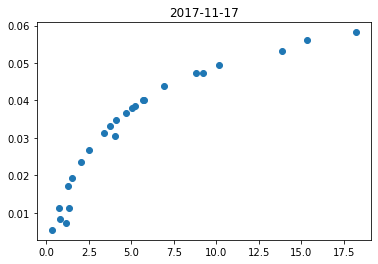

In [80]:
j = 970

plt.title(dates[j].date())
plt.scatter(bootstraped_rates_list[j].maturity, bootstraped_rates_list[j].rates);

## Diebold-Li weights generation

In [48]:
import statsmodels.api as sm

In [49]:
def get_loadings(m, tau):
    
    level = np.ones(m.shape[0])
    slope_hump = (1 - np.exp(- m / tau)) / (m / tau)
    hump =  - np.exp(- m / tau) 

    return level, slope_hump, hump

We set $\tau$ according to Diebold, Li 2006. The screnshot in the folder shows the way we obtained it.

In [61]:
def get_diebold_li_weights(day_number):

    df_shape = bootstraped_rates_list[day_number].shape[0]

    X = np.zeros([df_shape, 3])
    X[:,0], X[:,1], X[:,2] = get_loadings(m = bootstraped_rates_list[day_number].maturity.values, tau = 0.717313)
       
    y = bootstraped_rates_list[day_number].rates.values

    model = sm.OLS(y, X)
    beta = model.fit().params
    
    ns_theta = np.zeros(4)
    ns_theta[0] = 0.717313
    ns_theta[1] = beta[0]
    ns_theta[2] = beta[1] - beta[2]
    ns_theta[3] = beta[2]

    return ns_theta

In [62]:
%%time

diebold_li_weights = pd.DataFrame(np.zeros([bonds_prices.shape[0], 4]), index = dates,
                                  columns = ['tau', 'beta0', 'beta1', 'beta2'])

for i in range(diebold_li_weights.shape[0]):
    diebold_li_weights.iloc[i] = get_diebold_li_weights(i)
    
diebold_li_weights.to_csv(path + 'Data/New_data/diebold_li.csv')

CPU times: user 679 ms, sys: 4.15 ms, total: 683 ms
Wall time: 687 ms


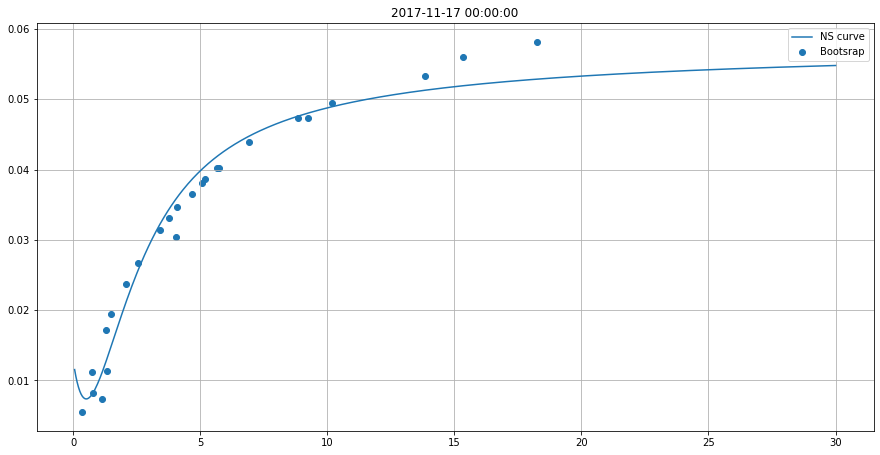

In [79]:
j = 970

m = np.linspace(0, 30, 600)
plt.figure(figsize = (15,7.5))
plt.grid()
plt.plot(m, ns(m, get_diebold_li_weights(j)), label = 'NS curve')
plt.title(dates[j])
plt.scatter(bootstraped_rates_list[j].maturity, bootstraped_rates_list[j].rates, label = 'Bootsrap')
plt.legend();

### Calculating yields

In [719]:
yields = pd.DataFrame(np.zeros([bonds_prices.shape[0], 4]), index = dates,
                      columns = ['3-month', '2-year', '10-year', 'longest'])

for i in range(len(dates)):
    sorted_bonds = maturity_matrix.iloc[i].sort_values()
    sorted_bonds.dropna(inplace=True)
    
    month_3_bond = sorted_bonds.iloc[(sorted_bonds-1/4).abs().argsort()].index[0]
    year_2_bond = sorted_bonds.iloc[(sorted_bonds-2).abs().argsort()].index[0]
    year_10_bond = sorted_bonds.iloc[(sorted_bonds-10).abs().argsort()].index[0]
    longest_bond = sorted_bonds.index[-1]
    
    yields.at[dates[i], '3-month'] = irr_matrix[dates[i]:dates[i]][month_3_bond]
    yields.at[dates[i], '2-year'] = irr_matrix[dates[i]:dates[i]][year_2_bond]
    yields.at[dates[i], '10-year'] = irr_matrix[dates[i]:dates[i]][year_10_bond]
    yields.at[dates[i], 'longest'] = irr_matrix[dates[i]:dates[i]][longest_bond]              

In [721]:
yields.to_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/Comparing-numerical-methods-for-term-structure-fitting/Data/New_data/yields.csv')

In [742]:
yields[dates[1]:dates[1]]

,3-month,2-year,10-year,longest
TRADEDATE,,,,
2014-01-08,0.059046,0.059046,0.074594,0.096524


In [761]:
i = 1

tau_1 = 30
tau_2 = 30
beta_0 = yields[dates[i]:dates[i]]['longest'][0]
beta_1 = yields[dates[i]:dates[i]]['10-year'][0] - yields[dates[i]:dates[i]]['3-month'][0]
beta_2 = 2 * yields[dates[i]:dates[i]]['2-year'][0] - yields[dates[i]:dates[i]]['3-month'][0] - yields[dates[i]:dates[i]]['10-year'][0]
beta_3 = beta_2

np.array([np.random.rand() * tau_1, np.random.rand() * tau_2, 3 * beta_0 * np.random.rand() - beta_0,
          3 * beta_1 * np.random.rand() - beta_1, 3 * beta_2 * np.random.rand() - beta_2, 
          3 * beta_3 * np.random.rand() - beta_3])

array([ 1.76745493e+01,  1.97433873e+01, -6.39291786e-02,  5.90868490e-03,
        1.50344858e-02,  1.16315710e-02])

In [868]:
yields[dates[100]:dates[100]]

,3-month,2-year,10-year,longest
TRADEDATE,,,,
2014-05-30,0.072912,0.079504,0.085895,0.093829


[ 2.85904732e+01  1.22720489e+01  9.32943961e-02 -9.68683742e-03
  8.04035835e-05 -3.19727717e-05]


/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/Comparing-numerical-methods-for-term-structure-fitting/thesis_library.py:31: RuntimeWarning: invalid value encountered in true_divide
  return beta0 + beta1 * (1 - np.exp(- m / tau1)) / (m / tau1) + beta2 * ((1 - np.exp(- m / tau1)) / (m / tau1) - np.exp(- m / tau1)) + beta3 * ((1 - np.exp(- m / tau2)) / (m / tau2) - np.exp(- m / tau2))


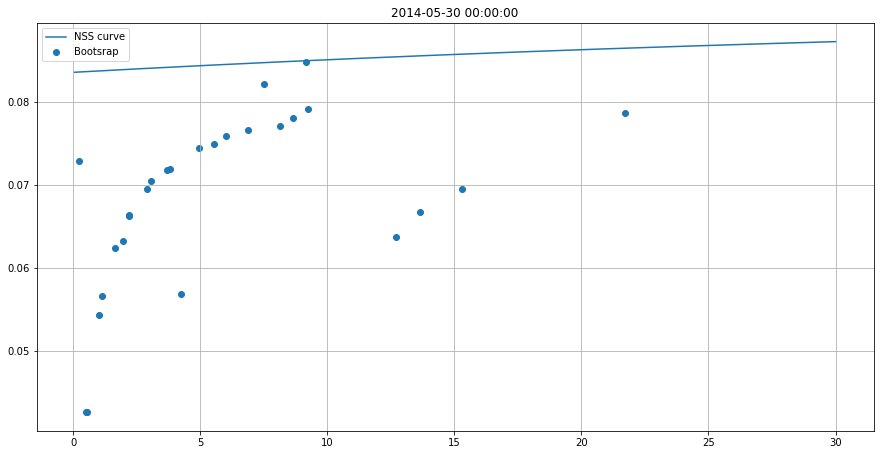

In [906]:
i = 100

tau_1 = 30
tau_2 = 30
beta_0 = yields[dates[i]:dates[i]]['longest'][0]
beta_1 = yields[dates[i]:dates[i]]['10-year'][0] - yields[dates[i]:dates[i]]['3-month'][0]
beta_2 = 2 * yields[dates[i]:dates[i]]['2-year'][0] - yields[dates[i]:dates[i]]['3-month'][0] - yields[dates[i]:dates[i]]['10-year'][0]
beta_3 = beta_2

theta = np.array([np.random.rand() * tau_1, np.random.rand() * tau_2, 3 * beta_0 * np.random.rand() - beta_0,
          3 * beta_1 * np.random.rand() - beta_1, 3 * beta_2 * np.random.rand() - beta_2, 
          3 * beta_3 * np.random.rand() - beta_3])

m = np.linspace(0, 30, 600)
plt.figure(figsize = (15,7.5))
plt.title(dates[i])
plt.grid()
plt.plot(m, thesis_library.nss(m, theta), label = 'NSS curve')
plt.scatter(bootstraped_rates_list[i].maturity, bootstraped_rates_list[i].rates, label = 'Bootsrap')
plt.legend()
print(theta);